In [ ]:
!pip install -q -U pip==20.2

!pip install git+https://github.com/google-research/tensorflow_constrained_optimization
!pip install -q tensorflow-datasets tensorflow
!pip install fairness-indicators \
  "absl-py==0.12.0" \
  "apache-beam<3,>=2.40" \
  "avro-python3==1.9.1" \
  "pyzmq==17.0.0"

In [2]:
#import
import os
import zipfile
import glob
import time
import datetime
import sys
import tempfile
import urllib
import re


import random
import numpy as np
import pandas as pd
import seaborn as sns
from collections import OrderedDict

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from tqdm.auto import tqdm




import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


tqdm.pandas()

AUTO = tf.data.experimental.AUTOTUNE


# Check GPU/TPU availabity devices.
pyVersion = !python --version
print('Using Tensorflow version:', tf.__version__, '\nwith GPU support:', tf.config.list_physical_devices('GPU'), '\nwith TPU support:', tf.config.list_physical_devices('TPU'), "\npython version : ", pyVersion )

Using Tensorflow version: 2.12.0 
with GPU support: [] 
with TPU support: [] 
python version :  ['Python 3.10.6']


In [3]:
projectPath = "/content/drive/MyDrive/projectDataScience/findThesis/fairness/"

checkpointFolder = "/checkpoint"
checkpointPath = os.path.join(projectPath, checkpointFolder)


rd_seed = 4

model_type = "CNN"
model_chk_vesion_name = "chk_{}".format(model_type)

# I. Dataset

## I-1 Load Dataset

In [4]:
gcs_base_dir = "gs://celeb_a_dataset/"
celeb_a_builder = tfds.builder("celeb_a", data_dir=gcs_base_dir, version='2.0.0')

celeb_a_builder.download_and_prepare()

num_test_shards_dict = {'0.3.0': 4, '2.0.0': 2} # Used because we download the test dataset separately
version = str(celeb_a_builder.info.version)
print('Celeb_A dataset version: %s' % version)



Celeb_A dataset version: 2.0.0


In [5]:
BATCH_SIZE = 64
ATTR_KEY = "attributes"
IMAGE_KEY = "image"
LABEL_KEY = "Smiling"
GROUP_AGE_KEY = "Young"
GROUP_SEX_KEY = "Male"
IMAGE_SIZE = 128
classifier_prefix = "classifier"




def preprocess_input_dict(feat_dict):
  # Separate out the image and target variable from the feature dictionary.
  image = feat_dict[IMAGE_KEY]
  label = feat_dict[ATTR_KEY][LABEL_KEY]
  group_age = feat_dict[ATTR_KEY][GROUP_AGE_KEY]
  group_sex = feat_dict[ATTR_KEY][GROUP_SEX_KEY]

  # Resize and normalize image.
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE], )
  image /= 255.0

  # Cast label and group to float32.
  label = tf.cast(label, tf.float32)
  group_age = tf.cast(group_age, tf.float32)
  group_sex = tf.cast(group_sex, tf.float32)

  feat_dict[IMAGE_KEY] = image
  feat_dict[ATTR_KEY][LABEL_KEY] = label
  feat_dict[ATTR_KEY][GROUP_AGE_KEY] = group_age
  feat_dict[ATTR_KEY][GROUP_SEX_KEY] = group_sex

  return feat_dict

get_image_and_label = lambda feat_dict: (feat_dict[IMAGE_KEY], feat_dict[ATTR_KEY][LABEL_KEY])
get_image_label_and_group = lambda feat_dict: ( (feat_dict[IMAGE_KEY], feat_dict[ATTR_KEY][GROUP_AGE_KEY]) , feat_dict[ATTR_KEY][LABEL_KEY])

In [6]:
# Train data returning either 2 or 3 elements (the third element being the group)
def celeb_a_train_data_wo_group(batch_size, repeat=False):
  celeb_a_train_data = celeb_a_builder.as_dataset(split='train').shuffle(1024)
  if repeat: celeb_a_train_data = celeb_a_train_data.repeat()
  celeb_a_train_data = celeb_a_train_data.batch(batch_size).map(preprocess_input_dict)
  return celeb_a_train_data.map(get_image_and_label)
def celeb_a_train_data_w_group(batch_size, repeat=False):
  celeb_a_train_data = celeb_a_builder.as_dataset(split='train').shuffle(1024)
  if repeat: celeb_a_train_data = celeb_a_train_data.repeat()
  celeb_a_train_data = celeb_a_train_data.batch(batch_size).map(preprocess_input_dict)
  return celeb_a_train_data.map(get_image_label_and_group)


#Train data
celeb_a_train_data = celeb_a_train_data_w_group(BATCH_SIZE, repeat=True)

# Test data for the overall evaluation
celeb_a_test_data = celeb_a_builder.as_dataset(split='test').batch(1).map(preprocess_input_dict).map(get_image_label_and_group)



#group dataset
unbc_celeb_a_test_data = celeb_a_test_data.unbatch()
celeb_test_group_ag1   = unbc_celeb_a_test_data.filter( lambda x, y:  tf.math.equal(x[1], 1) ).batch(1)
celeb_test_group_ag0   = unbc_celeb_a_test_data.filter( lambda x, y:  tf.math.equal(x[1], 0) ).batch(1)

celeb_test_group_ag1_bz   = unbc_celeb_a_test_data.filter( lambda x, y:  tf.math.equal(x[1], 1) ).batch(BATCH_SIZE)
celeb_test_group_ag0_bz   = unbc_celeb_a_test_data.filter( lambda x, y:  tf.math.equal(x[1], 0) ).batch(BATCH_SIZE)


unbc_celeb_a_train_data = celeb_a_train_data.unbatch()
celeb_train_group_ag1   = unbc_celeb_a_train_data.filter( lambda x, y:  tf.math.equal(x[1], 1) ).batch(BATCH_SIZE)
celeb_train_group_ag0   = unbc_celeb_a_train_data.filter( lambda x, y:  tf.math.equal(x[1], 0) ).batch(BATCH_SIZE)

smiling:  tf.Tensor([1.], shape=(1,), dtype=float32)
young:   tf.Tensor([1.], shape=(1,), dtype=float32)


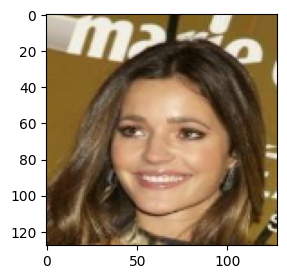

In [ ]:
for test_batch in celeb_a_test_data.take(1):
  (x, z), y = test_batch
  print("smiling: ", y)
  print("young:  ", z)

  fig = plt.figure(figsize=(3, 3))
  plt.imshow(x[0])


# Model
CNN  + classifier



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   896         ['input_image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

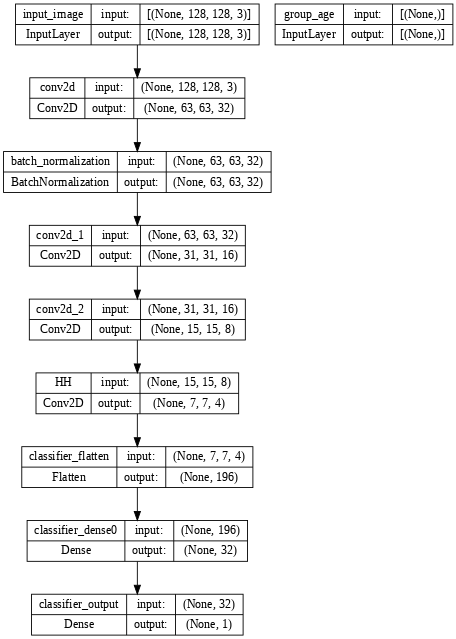

In [7]:


def create_model():

  inpImg      = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), dtype= tf.dtypes.float32, name='input_image',  )
  inpGroup    = tf.keras.Input(shape = (), dtype= tf.dtypes.bool, name='group_age',  ) #not used

  activation = "relu" #  "tanh" #
  initializer = tf.keras.initializers.GlorotNormal(seed=0)

  x = tf.keras.layers.Conv2D( filters=32, kernel_size=3, strides=(2, 2), activation=activation)(inpImg)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D( filters=16, kernel_size=3, strides=(2, 2), activation=activation,)(x)
  x = tf.keras.layers.Conv2D( filters=8,  kernel_size=3, strides=(2, 2), activation=activation,)(x)

  H = tf.keras.layers.Conv2D( filters=4,  kernel_size=3, strides=(2, 2), activation=activation, name= "HH")(x)
  #tf.keras.layers.GlobalAveragePooling2D()(x)

  x = tf.keras.layers.Flatten(name= classifier_prefix+"_flatten")(H)
  x = tf.keras.layers.Dense(32, activation=activation, kernel_initializer=initializer, name= classifier_prefix + "_dense0")(x)
  #x = #tf.keras.layers.Dropout(0.25,)(x)
  output =  tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, name= classifier_prefix+"_output")(x)

  return tf.keras.Model(inputs=[inpImg, inpGroup], outputs=[output, H])
  #return tf.keras.Model(inputs=[inpImg, inpGroup], outputs=output)



# BinaryCrossentropy loss object
binary_ce_obj = tf.keras.losses.BinaryCrossentropy(
              from_logits=False,
              label_smoothing=0.0,
              axis=-1,
              reduction=tf.keras.losses.Reduction.AUTO,
              name='binary_crossentropy'
          )




def create_compiled_model(keras_model = None, Optimizer=None):
    if keras_model == None: keras_model = create_model()
    keras_model = tf.keras.Model(inputs=keras_model.input, outputs=keras_model.output[0])

    METRICS = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.TruePositives(thresholds=None, name="TP", dtype=tf.float32),
                tf.keras.metrics.TrueNegatives(thresholds=None, name="TN", dtype=tf.float32),
                tf.keras.metrics.FalsePositives(thresholds=None, name="FP", dtype=tf.float32),
                tf.keras.metrics.FalseNegatives(thresholds=None, name="FN", dtype=tf.float32),
                ]
    LOSS = binary_ce_obj

    if Optimizer == None: Optimizer = tf.keras.optimizers.Adam(10**-3)

    keras_model.compile(
      optimizer= Optimizer,
      loss=LOSS,
      metrics=METRICS
    )
    return keras_model, Optimizer


#build CNN model
simple_model, sm_Optimizer = create_compiled_model()
print(simple_model.summary())
display(tf.keras.utils.plot_model(simple_model, show_shapes=True, dpi=64,) )  # rankdir='LR',) ) )


fair_model = create_model()
fm_Optimizer = tf.keras.optimizers.Adam(10**-3)

#build checkpoint obj
checkpoint_path = os.path.join(projectPath,  model_chk_vesion_name)
ckpt = tf.train.Checkpoint(simple_model = simple_model,  sm_Optimizer = sm_Optimizer, fair_model=fair_model, fm_Optimizer=fm_Optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# restoring the latest checkpoint in checkpoint_path
if ckpt_manager.latest_checkpoint:

  # assert_existing_objects_matched()
  print(ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial())
  #ckpt.restore(ckpt_manager.latest_checkpoint).assert_consumed().assert_existing_objects_matched()

In [8]:
#https://github.com/google/wasserstein-dist/blob/master/wasserstein.py
class Wasserstein(object):
  """Class to hold (ref to) data and compute Wasserstein distance."""

  def __init__(self, source_gen, src_bz, target_gen, trg_bz, fx, ws_optimizer=None, basedist=None):
    """Inits Wasserstein with source and target data."""
    self.source_gen = source_gen
    self.source_bs  = src_bz
    self.target_gen = target_gen
    self.target_bs  = trg_bz
    self.gradbs = self.source_bs  # number of source sample to compute gradient
    if basedist is None:  basedist = self.l2dist
    self.basedist = basedist
    self.current_model = fx

    self.vtilde = tf.Variable(tf.zeros([1, self.target_bs]), name='vtilde')
    self.v = tf.Variable(tf.zeros([1, self.target_bs]), name='v')
    self.k = tf.Variable(1., name='k')

    self.source_next_iter = iter(self.source_gen)
    self.target_next_iter = iter(self.target_gen)
    self.grade_tape = None
    if ws_optimizer is None: ws_optimizer = tf.keras.optimizers.Adam(10**-3)
    self.ws_optimizer = ws_optimizer

  def l2dist(self, source, target):
    """Computes pairwise Euclidean distances in tensorflow."""
    def flatten_batch(x):
      dim = tf.reduce_prod(tf.shape(x)[1:])
      return tf.reshape(x, [-1, dim])
    def scale_batch(x):
      dim = tf.reduce_prod(tf.shape(x)[1:])
      return x/tf.sqrt(tf.cast(dim, tf.float32))
    def prepare_batch(x):
      return scale_batch(flatten_batch(x))

    target_flat = prepare_batch(target)  # shape: [bs, nt]
    target_sqnorms = tf.reduce_sum(tf.square(target_flat), axis=1, keepdims=True)
    target_sqnorms_t = tf.transpose(target_sqnorms)

    source_flat = prepare_batch(source)  # shape: [bs, ns]
    source_sqnorms = tf.reduce_sum(tf.square(source_flat), axis=1, keepdims=True)

    dotprod = tf.matmul(source_flat, target_flat, transpose_b=True)  # [ns, nt]
    sqdist = source_sqnorms - 2*dotprod + target_sqnorms_t
    dist = tf.sqrt(tf.nn.relu(sqdist))  # potential tiny negatives are suppressed
    return dist  # shape: [ns, nt]


  def grad_hbar(self, v, source_next_data, target_next_data,  gradbs, reuse=True):
    """Compute gradient of hbar function for Wasserstein iteration."""
    source_data  = source_next_data
    target_data  = target_next_data

    c_xy = self.basedist(source_data, target_data)
    c_xy -= v  # [gradbs, trnsize]
    idx = tf.argmin(c_xy, axis=1)               # [1] (index of subgradient)
    target_bs = self.target_bs
    xi_ij = tf.one_hot(idx, target_bs)  # find matches, [gradbs, trnsize]
    xi_ij = tf.reduce_mean(xi_ij, axis=0, keepdims=True)    # [1, trnsize]
    grad = 1./target_bs - xi_ij  # output: [1, trnsize]
    return grad


  def hbar(self, v, source_data, target_data, reuse=True):
    """Compute value of hbar function for Wasserstein iteration."""

    c_xy = self.basedist(source_data, target_data)
    c_avg = tf.reduce_mean(c_xy)
    c_xy -= c_avg
    c_xy -= v

    c_xy_min = tf.reduce_min(c_xy, axis=1)  # min_y[ c(x, y) - v(y) ]
    c_xy_min = tf.reduce_mean(c_xy_min)     # expectation wrt x
    return tf.reduce_mean(v, axis=1) + c_xy_min + c_avg # avg wrt y

  def k_step(self, k, v, vt, c, source_next_data, target_next_data, reuse=True):
    """Perform one update step of Wasserstein computation."""
    grad_h = self.grad_hbar(vt, source_next_data, target_next_data, gradbs=self.gradbs, reuse=reuse)

    #vt.assign_add(c/tf.sqrt(k)*grad_h, name='vt_assign_add')
    vt = tf.math.add(x = vt, y = c/tf.sqrt(k)*grad_h, name='vt_assign_add')

    v = ((k-1.)*v + vt)/k
    return k+1, v, vt, c



  def reset_var(self,):
    self.v.assign(tf.zeros([1, self.target_bs]))  # reset every time graph is evaluated
    self.vtilde.assign(tf.zeros([1, self.target_bs]))



  def fx(self, data, training=True):
     return self.current_model( data[0], training=training   )[1]

  @tf.function
  def ws_train_step(self, v, source_next_data, target_next_data, training):
    #self.v = tf.stop_gradient(self.v)
    with tf.GradientTape()  as tape:
      source_next_dataH, target_next_dataH =  self.fx(source_next_data),  self.fx( target_next_data )
      val = self.hbar(v, source_next_dataH, target_next_dataH,)
      ws_loss = tf.reduce_mean(val)

    if training:
      train_var = [tr_var for tr_var in self.current_model.trainable_variables if not (classifier_prefix in tr_var.name ) ]
      ws_grads = tape.gradient(ws_loss, train_var)
      self.ws_optimizer.apply_gradients( zip(ws_grads,  train_var ) )

    return ws_loss




  def dist(self,  C=.1,  nsteps=10, training = True, reset=False):
    """Compute Wasserstein distance (Alg.2 in [Genevay etal, NIPS'16])."""
    target_bs    = self.target_bs
    self.k = 1.0 #self.k.assign(1.)  # restart averaging from 1 in each call
    if reset: self.reset_var()  # used for randomly sampled target data, otherwise warmstart

    # (unrolled) optimization loop. first iteration, create variables
    source_next_data, target_next_data = self.fx( next( self.source_next_iter ), training ) , self.fx( next(self.target_next_iter), training )
    self.k, self.v, self.vtilde, C = self.k_step(self.k, self.v, self.vtilde, C, source_next_data, target_next_data, reuse=False)

    for _ in range(nsteps):
      source_next_data, target_next_data =  self.fx( next( self.source_next_iter ) ),  self.fx( next(self.target_next_iter) )
      # (unrolled) optimization loop. other iterations, reuse variables
      self.k, self.v, self.vtilde, C = self.k_step(self.k, self.v, self.vtilde, C, source_next_data, target_next_data )


    v = self.v
    source_next_data, target_next_data =  next( self.source_next_iter ),  next(self.target_next_iter)
    ws_loss = self.ws_train_step(v, source_next_data, target_next_data, training)

    return ws_loss

In [11]:
WD_C = 1.3


#train model
@tf.function
def tain_classifier_step(current_model, data_batch,  current_optimizer, Lambda):
  """Performs training on the dataset."""

  x_batch, y_batch = data_batch

  with tf.GradientTape()  as tape:
    # Compute a forward pass on the batch of data
    yhat_all = current_model( x_batch, training=True )
    loss_bin_ce = binary_ce_obj(y_batch, yhat_all[0])

  train_var = current_model.trainable_variables  # [tr_var for tr_var in current_model.trainable_variables if  (classifier_prefix in tr_var.name ) ] #
  # Compute the corresponding gradient
  grads = tape.gradient(loss_bin_ce, train_var)
  # Apply the gradient using a client optimizer.
  current_optimizer.apply_gradients( zip(grads, train_var) )

  return None




def fit_with_H_constraint(current_model, dataset_all, dataset_g0, dataset_g1, num_iter, epochs,  current_optimizer, Lambda):
  """Performs training on the dataset."""

  ws_Optimizer = tf.keras.optimizers.Adam(10**-3)
  ws_loss_obj = Wasserstein(  source_gen = dataset_g0 , src_bz=BATCH_SIZE, target_gen=dataset_g1, trg_bz=BATCH_SIZE, fx=current_model, ws_optimizer=ws_Optimizer)

  for ep in range(epochs):
  # Use the current_optimizer to update the model.
    #for batch_num in range(num_iter):
    for iter_idx, next_all in enumerate(dataset_all.take(num_iter)):
      print(".", end="" if  ((iter_idx+1)%100  ) else "\n" )
      tain_classifier_step(current_model, next_all,  current_optimizer, Lambda = 1)

    ws_loss = ws_loss_obj.dist( C=WD_C, nsteps=num_iter, training=True)


  return None



In [12]:
EPOCHS, NBR_ITER = 10, 10

#train simple modele
simple_model.fit(celeb_a_train_data,  epochs=EPOCHS, steps_per_epoch= NBR_ITER) #,

#train modele with Wasserstein-2  Hz=1, Hz=0 distance constraint
fit_with_H_constraint(fair_model, celeb_a_train_data, celeb_train_group_ag0, celeb_train_group_ag1, NBR_ITER, EPOCHS,  fm_Optimizer,  10 )

#ckpt_manager.save();

Epoch 1/10
10/10 [==============================] - 20s 609ms/step - loss: 0.6869 - accuracy: 0.5547 - TP: 203.0000 - TN: 152.0000 - FP: 156.0000 - FN: 129.0000
Epoch 2/10
10/10 [==============================] - 6s 576ms/step - loss: 0.6610 - accuracy: 0.6250 - TP: 162.0000 - TN: 238.0000 - FP: 88.0000 - FN: 152.0000
Epoch 3/10
10/10 [==============================] - 5s 465ms/step - loss: 0.6304 - accuracy: 0.6859 - TP: 204.0000 - TN: 235.0000 - FP: 92.0000 - FN: 109.0000
Epoch 4/10
10/10 [==============================] - 5s 497ms/step - loss: 0.5865 - accuracy: 0.6938 - TP: 222.0000 - TN: 222.0000 - FP: 96.0000 - FN: 100.0000
Epoch 5/10
10/10 [==============================] - 4s 396ms/step - loss: 0.4907 - accuracy: 0.7953 - TP: 215.0000 - TN: 294.0000 - FP: 59.0000 - FN: 72.0000
Epoch 6/10
10/10 [==============================] - 4s 389ms/step - loss: 0.5364 - accuracy: 0.7266 - TP: 220.0000 - TN: 245.0000 - FP: 83.0000 - FN: 92.0000
Epoch 7/10
10/10 [============================

In [43]:
#fairness evaluation
TP, TN, FP, FN, Accuracy, Precision, Recall = "TP", "TN", "FP", "FN", "accuracy", "precision", "recall"

def plotXpRes(_current_model, xp_title):
  _current_model_compiled, _ = create_compiled_model(keras_model = _current_model, Optimizer=None)

  all_data_metric            = _current_model_compiled.evaluate(celeb_a_test_data,    return_dict=True,)
  group_young_data_metric    = _current_model_compiled.evaluate(celeb_test_group_ag1, return_dict=True,)
  group_notyoung_data_metric = _current_model_compiled.evaluate(celeb_test_group_ag0, return_dict=True,)



  _g1_btach = next(iter(celeb_test_group_ag1_bz))
  _g0_btach = next(iter(celeb_test_group_ag0_bz))
  _g01_batch = (tf.concat( values=[_g0_btach[0][0], _g1_btach[0][0] ], axis=0, name='_g01_batchx'),  tf.concat( values=[_g0_btach[0][1], _g1_btach[0][1] ], axis=0, name='_g01_batchz')    )

  H_group_all      = tf.reduce_mean(  _current_model(   _g01_batch,   training=False  )[1], axis=0   )
  H_group_young    = tf.reduce_mean(  _current_model(   _g1_btach[0], training=False  )[1], axis=0   )
  H_group_notyoung = tf.reduce_mean(  _current_model(   _g0_btach[0], training=False  )[1], axis=0   )


  def get_conf_mat(_current_metric):
    mat_format = [ [TP, FP], [FN, TN] ]
    all_dat_conf_mat = pd.DataFrame( [ [ _current_metric[col] for col in row ] for row in mat_format ] )
    all_dat_conf_text = [ [  "{} : {}".format( col,  _current_metric[col])   for col in row ] for row in mat_format ]
    _precision = round(  _current_metric[TP]/ max((_current_metric[TP] + _current_metric[FP]), 1), 4)
    _recall    = round(  _current_metric[TP]/ max((_current_metric[TP] + _current_metric[FN]), 1), 4)
    _accuracy  = round(  _current_metric[Accuracy],  4)
    return {"df_cm": all_dat_conf_mat, "text" : all_dat_conf_text, Precision: _precision , Recall :_recall, Accuracy: _accuracy  }


  def get_WS_loss():
    ws_loss_obj = Wasserstein(  source_gen = celeb_test_group_ag0_bz, src_bz=BATCH_SIZE, target_gen=celeb_test_group_ag1_bz, trg_bz=BATCH_SIZE, fx=_current_model, ws_optimizer=None)
    ws_loss = ws_loss_obj.dist( C=WD_C, nsteps=10, training=False)
    _ws_loss = round(ws_loss.numpy(), 4)
    return _ws_loss


  subtitle = [ "Metrics" ,   "H representation" ]
  titles   = ["All_data", "Young_group", "Not_Young_group"]

  all_data_conf_mat,  group_young_data_conf_mat,  group_notyoung_conf_mat = get_conf_mat(all_data_metric), get_conf_mat(group_young_data_metric), get_conf_mat(group_notyoung_data_metric)

  metric_relative_distance = { elt : round( group_young_data_conf_mat[elt] - group_notyoung_conf_mat[elt], 4) for elt in [  Accuracy, Precision,  Recall]  }
  subtitle[0] = subtitle[0] + ": relative distance M(Grp1 - Grp0) => {} : {}, Precision : {}, Recall: {}".format( Accuracy, metric_relative_distance[Accuracy], metric_relative_distance[Precision], metric_relative_distance[Recall])


  conf_mat_all_data = [ all_data_conf_mat , group_young_data_conf_mat, group_notyoung_conf_mat]
  plot_data_row0 = [ {"data": conf_mat, "title": "{} => {} : {}, Precision : {}, Recall: {}".format(title, Accuracy, conf_mat[Accuracy], conf_mat[Precision], conf_mat[Recall])  } for conf_mat, title in zip(conf_mat_all_data, titles) ]


  h_idx = 0
  H_mat_data = [ H_group_all,  H_group_young, H_group_notyoung  ]
  H_mat_data = [elt[:, :, h_idx] for elt in H_mat_data]
  plot_data_row1 = [  {"data": h_, "title" : "{}  {}".format(c_title_,  h_names)} for  c_title_, h_, h_names in zip(titles, H_mat_data, ["H(G0 U G1)", "H(G1)", "H(G0)"])  ]

  subtitle[1] += ": Wasserstein-2 distance  WD ( H(G1), H(G0) ) = {:.4f}".format( get_WS_loss() )



  rows, cols = 2, 3
  fig = plt.figure(constrained_layout=True, figsize=(18, 8))
  fig.suptitle(xp_title, fontsize=13)
  subfigs = fig.subfigures(nrows=rows, ncols=1,  height_ratios=[2/5, 3/5])

  # create 1x3 subplots per subfig
  row, subfig = 0, subfigs[0]
  subfig.suptitle(subtitle[row], fontsize = 11)
  axs = subfig.subplots(nrows=1, ncols=cols)
  for ax, _current_plot_data in zip(axs, plot_data_row0) :
    ax.axis('off')
    ax.set_title(_current_plot_data["title"], fontsize = 10)
    sns.heatmap(_current_plot_data["data"]["df_cm"], annot=_current_plot_data["data"]["text"], fmt="", cbar=False, ax=ax)


  # create 1x3 subplots per subfig
  row, subfig = 1, subfigs[1]
  subfig.suptitle(subtitle[row], fontsize = 11 )
  axs = subfig.subplots(nrows=1, ncols=cols)
  for ax, _current_plot_data in zip(axs, plot_data_row1) :
    ax.axis('off')
    ax.set_title(_current_plot_data["title"], fontsize = 10)
    ax.matshow(_current_plot_data["data"])


  plt.axis('off')
  plt.show()


  return all_data_conf_mat,  group_young_data_conf_mat,  group_notyoung_conf_mat

-------------------simple_model Xperience results---------------------
4848/4848 [==============================] - 50s 10ms/step - loss: 0.6002 - accuracy: 0.7523 - TP: 2114.0000 - TN: 1533.0000 - FP: 825.0000 - FN: 376.0000


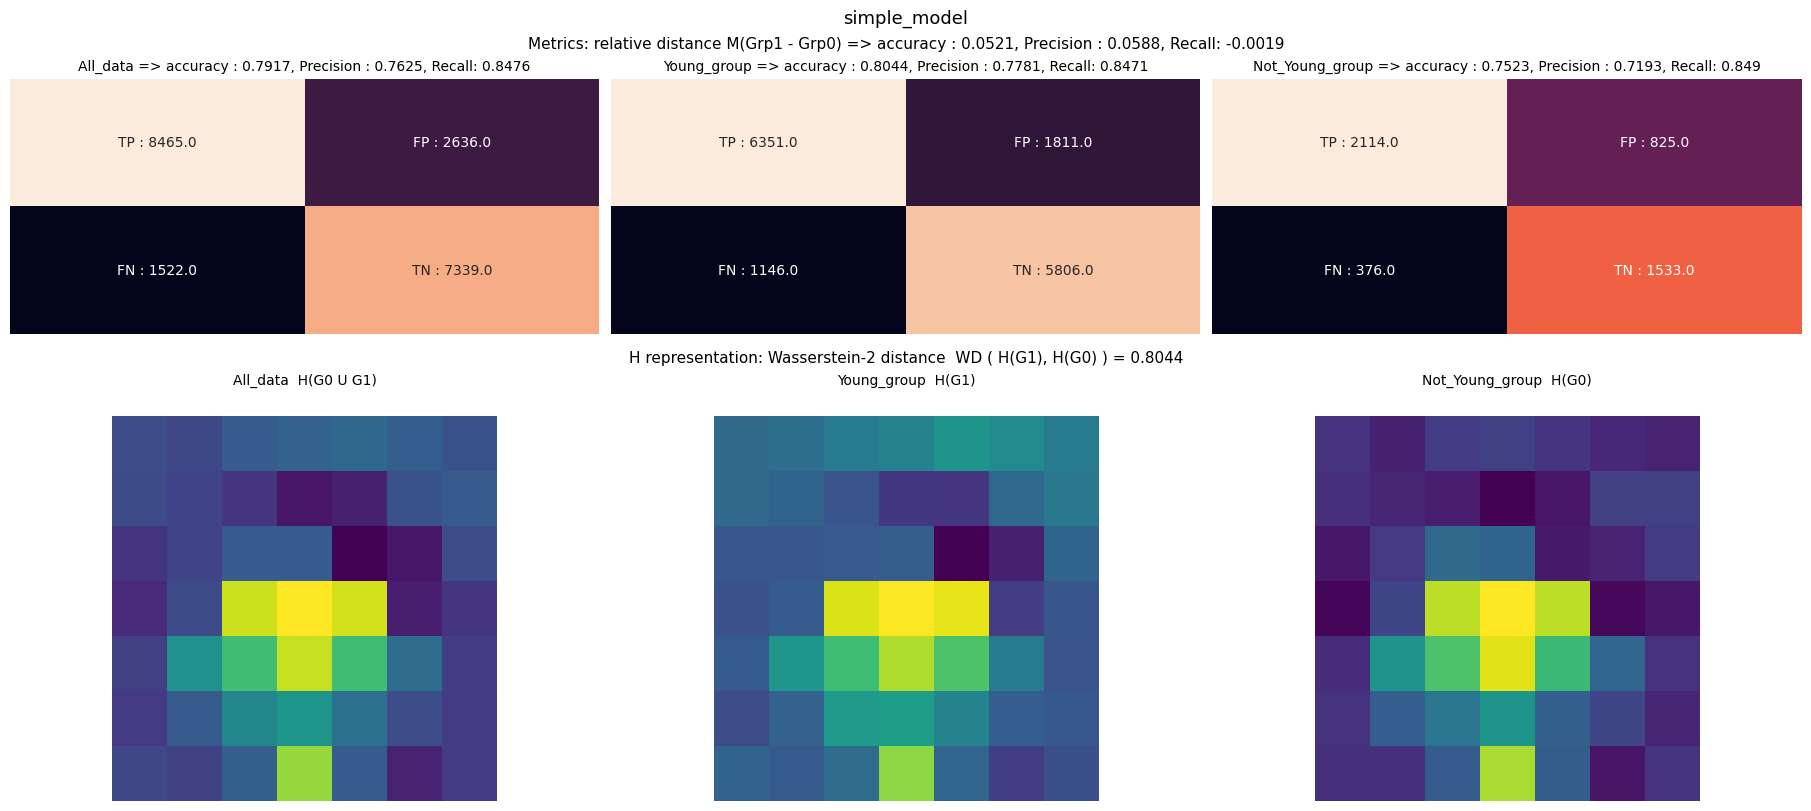



------------------fair_model Xperience results----------------------
4848/4848 [==============================] - 51s 10ms/step - loss: 0.4782 - accuracy: 0.7737 - TP: 2065.0000 - TN: 1686.0000 - FP: 672.0000 - FN: 425.0000


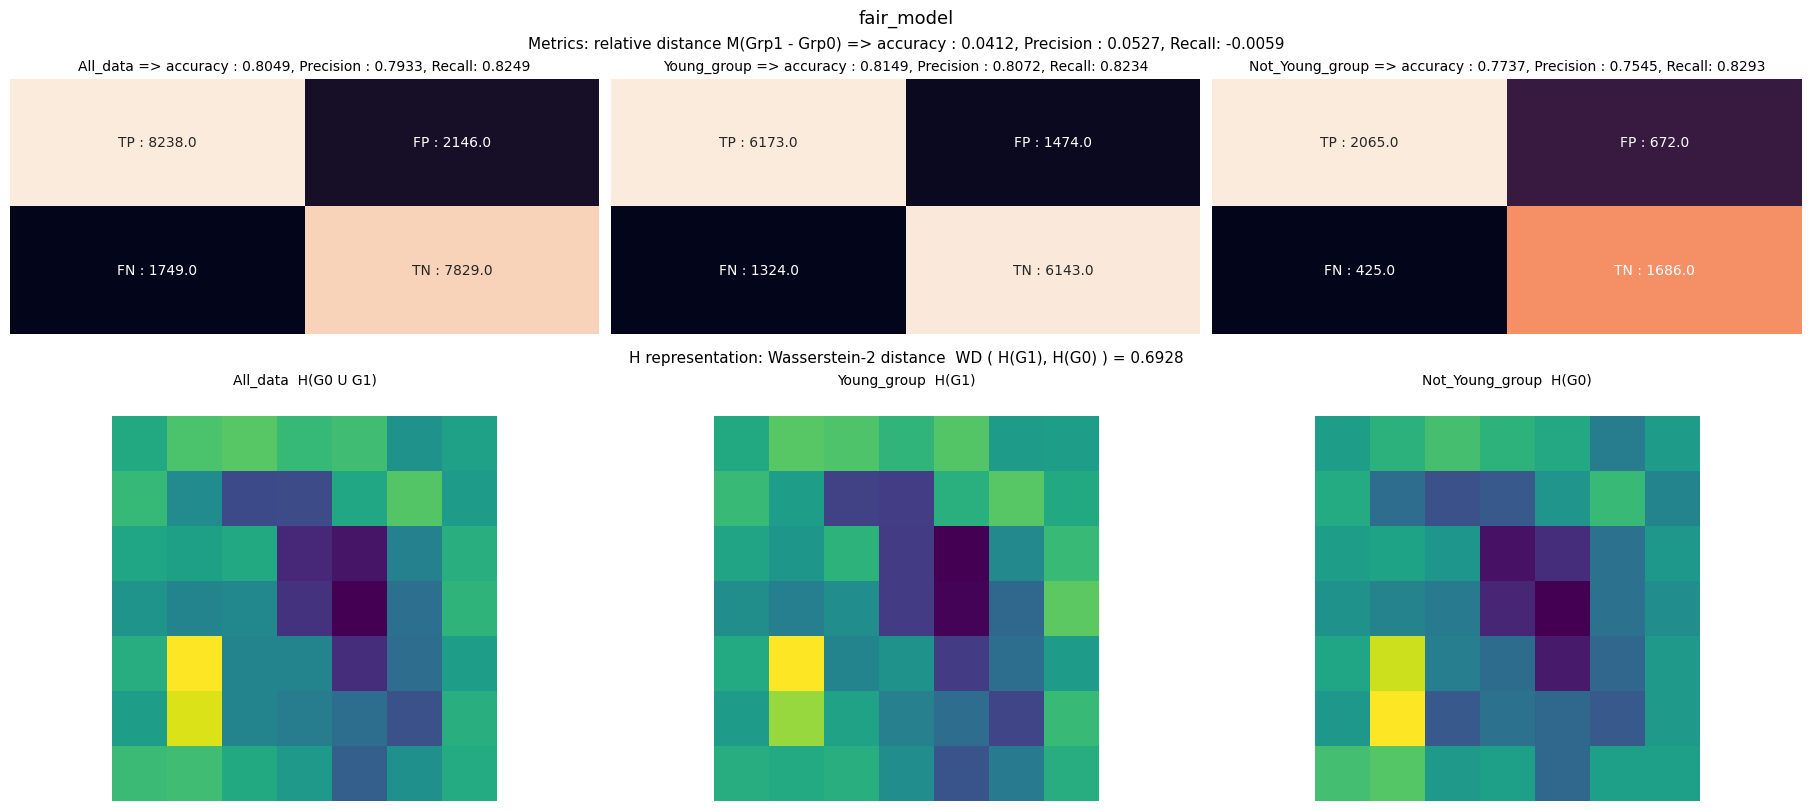

In [44]:
simple_model_test = create_model()
simple_model_test.set_weights(simple_model.get_weights())
print("-------------------simple_model Xperience results---------------------")
simple_model_XpRes = plotXpRes(simple_model_test, "simple_model")
print("\n\n------------------fair_model Xperience results----------------------")
fair_model_XpRes = plotXpRes(fair_model, "fair_model")


In [32]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

def savedata(data):
  fpath = "/content/drive/MyDrive/projectDataScience/findThesis/fairness/xpData.pkl"
  with open(fpath, 'wb') as pfile:
      pickle.dump(data, pfile, protocol=pickle.HIGHEST_PROTOCOL)

  print("file saved")
  return None

##save weights
#savedata( {"simple_model": simple_model.get_weights(), "fair_model": fair_model.get_weights()  }  )

Mounted at /content/drive
file saved


In [42]:
#save notebook as PDF

# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# !pip install pypandoc

!cp /content/drive/MyDrive/projectDataScience/findThesis/fairness/fairness.ipynb ./
!jupyter nbconvert --to PDF "fairness.ipynb"

[NbConvertApp] Converting notebook fairness.ipynb to PDF
[NbConvertApp] Support files will be in fairness_files/
[NbConvertApp] Making directory ./fairness_files
[NbConvertApp] Making directory ./fairness_files
[NbConvertApp] Making directory ./fairness_files
[NbConvertApp] Making directory ./fairness_files
[NbConvertApp] Writing 103056 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 304800 bytes to fairness.pdf
